In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mysql.connector as con
from abc import ABC,abstractmethod
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

In [2]:
class Connection:
    @staticmethod
    def getConnection():
        db_connection = con.connect(                 #Creating Connection
            host="localhost",
            user="root",
            password="alpha",
            database="electricity_billing_db"
        )
        return db_connection

In [3]:
class User(ABC):
    def __init__(self):
        pass

In [4]:
class Customer(User):
    def __init__(self,uid,uname,pin,fname,address,role):
        self.uid=uid
        self.uname=uname
        self.pin=pin
        self.fname=fname
        self.address=address
        self.role=role        

In [5]:
class Admin(User):
    def __init__(self,uid,uname,pin,fname,address,role):
        self.uid=uid
        self.uname=uname
        self.pin=pin
        self.fname=fname
        self.address=address
        self.role=role    
        
    def add_Customer(self,user_data,meter_data):
        db_con=Connection.getConnection()
        cursor = db_con.cursor()
        query = "INSERT INTO users (user_id,username, password, full_name, address, role) VALUES (%s,%s, %s, %s, %s, %s)"
        q="INSERT INTO meters (user_id,meter_number,meter_type,fixed_charges) VALUES (%s,%s, %s, %s)"
        cursor.execute(query,user_data)
        cursor.execute(q,meter_data)
        db_con.commit()
        db_con.close()
        print("Added Successfully!")
        
    def generate_bill(self,uid,user_details):
        
        month_data = { 1: "January", 2: "February", 3: "March",4: "April",5: "May",6: "June",7: "July",8: "August", 9: "September",10: "October",11: "November",12: "December"}
        
        db_con = Connection.getConnection()
        cursor = db_con.cursor(dictionary=True)
        pointer = db_con.cursor(dictionary=True)
        que = "SELECT * FROM meters WHERE user_id=%s;"
        query = "SELECT * FROM meter_readings WHERE user_id=%s;"
        
        cursor.execute(query, (uid,))
        mReading = cursor.fetchone()
        cursor.fetchall()
        
        pointer.execute(que, (uid,))
        meter = pointer.fetchone()
        
        pastReading = mReading["current_reading"]
        charges = meter["fixed_charges"]
        mType = meter["meter_type"]
        mNumber = meter["meter_number"]
        mailid=user_details['mail_id']
        # Input current reading and date
        while True:
            currentReading = int(input("Enter Current Meter Reading: "))
            year=int(input("Enter Year:"))
            month_int=int(input("Enter Month"))
            date=int(input("Enter Date:"))
            get_month=month_data[month_int]
            dt=str(year)+"-"+str(month_int)+"-"+str(date)
            if currentReading > pastReading:
                units_consumed = currentReading - pastReading
                totalAmount = (units_consumed * 10) + charges
                
                # Generate Bill
                print("\n" + "="*50)
                print("                 ELECTRICITY BILL                    ")
                print("="*50)
                print(f"User Name: {user_details['username']}")
                print(f"Customer's Name: {user_details['full_name']}")
                print(f"Date of Bill Generation: {dt}")
                print("="*50)
                
                print(f"Meter Number: {mNumber}")
                print(f"Meter Type: {mType}")
                print(f"Previous Reading: {pastReading}")
                print(f"Current Reading: {currentReading}")
                print(f"Units Consumed: {units_consumed}")
                print(f"Fixed Charges: {charges}")
                print("="*50)
                
                print(f"Total Amount Due: Rs. {totalAmount:.2f}")
                print("="*50)

                #Deleting Previous Readings
                delque="DELETE FROM meter_readings WHERE user_id=%s;"
                delcur=db_con.cursor()
                delcur.execute(delque,(uid,))
                db_con.commit()
                
                # Inserting New Readings
                mr=(uid,pastReading,currentReading,dt)
                bill=(uid,get_month,units_consumed,year)
                insertor=db_con.cursor()
                quer="INSERT INTO meter_readings (user_id,past_reading,current_reading,reading_date) VALUES (%s,%s, %s, %s)"
                qr="INSERT INTO current_year_bills (user_id,month,unit_consumed,year) VALUES (%s,%s, %s, %s)"
                insertor.execute(quer,mr)
                db_con.commit()
                insertor.execute(qr,bill)
                db_con.commit()

                #Inserting Due Amount In Payments Table
                payque="Insert INTO payments (user_id,amount,status) VALUES (%s,%s,%s)"
                values=(uid,totalAmount,"pending")
                paycursor=db_con.cursor()
                paycursor.execute(payque,values)
                db_con.commit()
                db_con.close() 
                break
                
            else:
                print("Current reading must be greater than the previous reading. Please try again.")
                
    def view_pending_bills(self):
            
        db_con = Connection.getConnection()
        cursor=db_con.cursor()
        query="Select * From payments Where status=%s;"
        cursor.execute(query,("pending",))
        data=cursor.fetchall()
        columns = [column[0] for column in cursor.description]
        df = pd.DataFrame(data, columns=columns)
        print(df.to_string(index=False))
        cursor.close()
        db_con.close()

    def months_analysis(self):

        db_con=Connection.getConnection()
        cursor=db_con.cursor()
        query="Select * From current_year_bills"
        cursor.execute(query)
        datas=cursor.fetchall()
        month_consumption={}
        for data in datas:
            month=data[1]
            units=data[2]
            month_consumption[month]=month_consumption.get(month,0)+units
        months = np.array(list(month_consumption.keys()))
        units = np.array(list(month_consumption.values()))
        plt.bar(months,units,color='skyblue')
      
        plt.title('Monthly Consumption', fontsize=14)
        plt.xlabel('Month', fontsize=12)
        plt.ylabel('Units Consumed', fontsize=12)
        
        plt.xticks(rotation=45)
    
        plt.tight_layout()
    
        plt.show()
        db_con.close()

In [6]:
class AdminInterface(Admin):
    def __init__(self):
        while(True):
            print()
            ch=int(input("Press 1 For Add Customer: \nPress 2 For Generate Bill:\nPress 3 For Pending Bills:\nPress 4 For Month Analysis:"))
            if ch==1:
                uid=int(input("Enter User Id:"))
                uname=str(input("Enter Username:"))
                password=str(input("Enter Password:"))
                fname=str(input("Enter Full Name:"))
                add=str(input("Enter Address:"))
                role=str(input("Enter Role:"))
                meter_number=str(("Enter Meter Number:"))
                meter_type=str(input("Enter Meter Type:"))
                if meter_type=="residential":
                    fixed_charges=550
                elif meter_type=="commercial":
                    fixed_charges=675
                else:
                    fixed_charges=680
                self.add_Customer((uid,uname,password,fname,add,role),(uid,meter_number,meter_type,fixed_charges))
            elif ch==2:
                while(True):
                    us_id=int(input("Enter User Id:"))
                    user_details=CheckUser.user_details(us_id)
                    if user_details:
                        print()
                        self.generate_bill(us_id,user_details)
                        break
                    else:
                        print("Customer Not Found,Kindly Enter User Id Again!")
            elif ch==3:
                self.view_pending_bills()
            elif ch==4:
                self.months_analysis()
            else:
                break

In [7]:
class CheckUser:
    def login(username,password):
        db_con=Connection.getConnection()
        cursor = db_con.cursor(dictionary=True)
        cursor.execute("SELECT * from users WHERE username=%s AND password=%s",(username,password))
        user=cursor.fetchone()
        if user:
            if user["role"]=='customer':
                return Customer(user["user_id"],user["username"],user["password"],user["full_name"],user["address"],user["role"])
            else:
                return user
        else:
            print("User Not Found!")
            return False
        db_con.close()
    def user_details(u_id):
        db_con=Connection.getConnection()
        cursor = db_con.cursor(dictionary=True)
        cursor.execute("SELECT * from users WHERE user_id=%s",(u_id,))
        user=cursor.fetchone()
        if user:
            return user
        else:
            print("User Not Found!")
            return False
        db_con.close()

Welcome To XYZ Billing System!!!
Enter Credentials To Go Ahead



Enter Username: admin_1
Enter Password: pass123


Press 1 For Add Customer: 
Press 2 For Generate Bill:
Press 3 For Pending Bills:
Press 4 For Month Analysis: 4


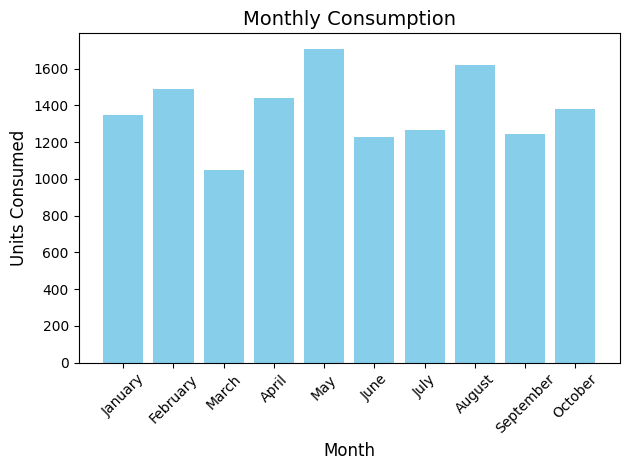

Press 1 For Add Customer: 
Press 2 For Generate Bill:
Press 3 For Pending Bills:
Press 4 For Month Analysis: 3


 user_id  amount  status
       1  2560.0 pending
       1  2550.0 pending
       1  2550.0 pending



KeyboardInterrupt: Interrupted by user

Press 1 For Add Customer: 
Press 2 For Generate Bill:
Press 3 For Pending Bills:
Press 4 For Month Analysis: 2


In [8]:
while(True):
    print("Welcome To XYZ Billing System!!!")
    print("Enter Credentials To Go Ahead")
    print()
    username=str(input("Enter Username:"))
    pin=str(input("Enter Password:"))
    user=CheckUser.login(username,pin)  
    if user:
        if user["role"]=="customer":
            pass
        else:
            print()
            admin=AdminInterface()
    else:
        break